By Prof. Seungchul Lee  
http://iai.postech.ac.kr/  
Industrial AI Lab at POSTECH  
(Translate to R by Gwangil Seo)

Table of Contents

   * [1. FFT with Sampling Frequency](#1.-FFT-with-Sampling-Frequency)
      + [1.1. Implementing FFT routine](#1.1.-Implementing-FFT-routine)
      + <a href="#1.2.-Single-sided-FFT-(or-Positive-FFT)">1.2. Single-sided FFT (or Positive FFT)</a>
   * [2. Extract Amplitude of the Specific Frequency](#2.-Extract-Amplitude-of-the-Specific-Frequency)
   * [3. Envelope Analysis](#3.-Envelope-Analysis)
      + [3.1. Beats](#3.1.-Beats)
      + [3.2. Modulation and Demodulation](#3.2.-Modulation-and-Demodulation)
   * <a href="#4.-STFT(Short-Time-Fourier-Transform)">4. STFT(Short-Time Fourier Transform)</a>

## 1. FFT with Sampling Frequency

### 1.1. Implementing FFT routine

In [1]:
Fs <- 1000  # Sampling frequency
T <- 1 / Fs  # Sampling period ( or sampling interval)

N <- 5000  # Total data points (singal length)

t <- (0:(N - 1)) * T  # Time vector (time range)

k <- 0:(N - 1)  # vector from 0 to N-1
f <- (Fs / N) * k  # frequency range

$$x[n] = 0.7\text{cos}(2\pi 60t) \Rightarrow f = 60$$
You can think this signal as a vibration signal from a rotating machinery with 60 Hz (or 60 X 60 = 3600 rpm)

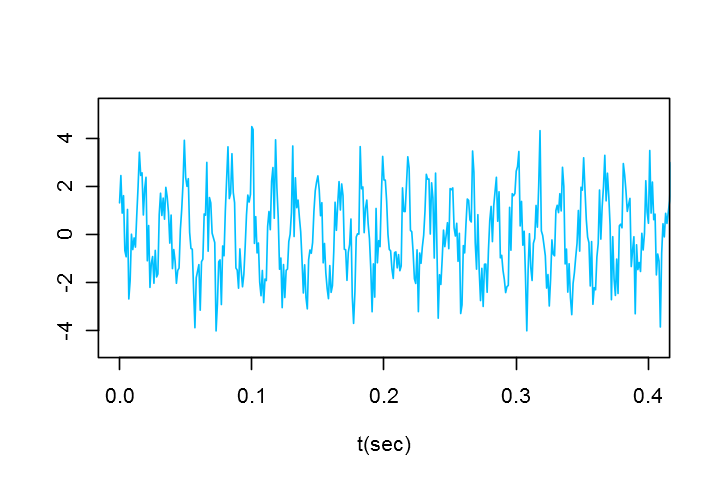

In [2]:
x <- 2 * cos(2 * pi * 60 * t)
xn <- x + 1 * rnorm(length(t))

options(repr.plot.width=6, repr.plot.height=4)
plot(t, xn, type = 'l', col = 'deepskyblue', lwd = 1, xlim = c(0, 0.4), xlab = 't(sec)', ylab = '')

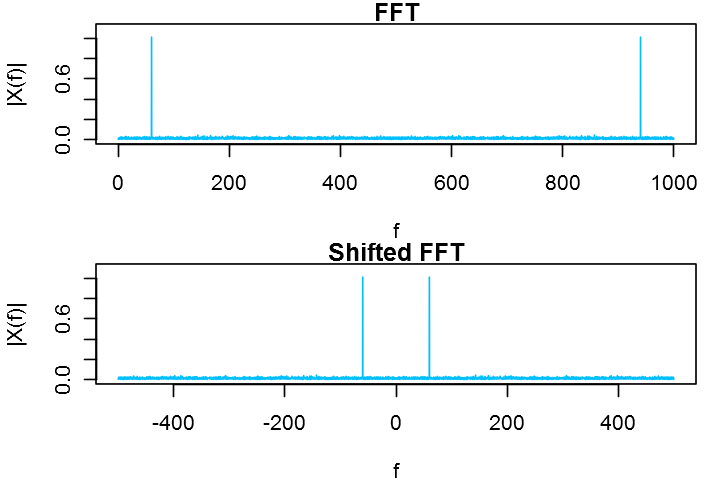

In [3]:
# original fft

xnt <- fft(xn) / N
fftshift <- function(data) {
  c(tail(data, round(length(data[-1])/2)), head(data, -round(length(data[-1])/2)))
}
xntshift <- fftshift(xnt)

kr <- c(seq(0, N / 2 - 1), seq(-N / 2, -1))
fr <- (Fs / N) * kr
fs <- fftshift(fr)

par(mfrow = c(2, 1), mar = c(4, 4, 1, 1))
plot(f, abs(xnt),  type = 'l', lwd = 1, col = 'deepskyblue', main = "FFT", xlab = "f", ylab = '|X(f)|', ylim = c(0, 1.1))
plot(fs, abs(xntshift),  type = 'l', lwd = 1, col = 'deepskyblue', main = "Shifted FFT", xlab = "f", ylab = '|X(f)|', ylim = c(0, 1.1))

### 1.2. Single-sided FFT (or Positive FFT)

 * Only want the first half of the FFT, since the last is redundant (symmetric)
 * 2 X amplitude except the DC component

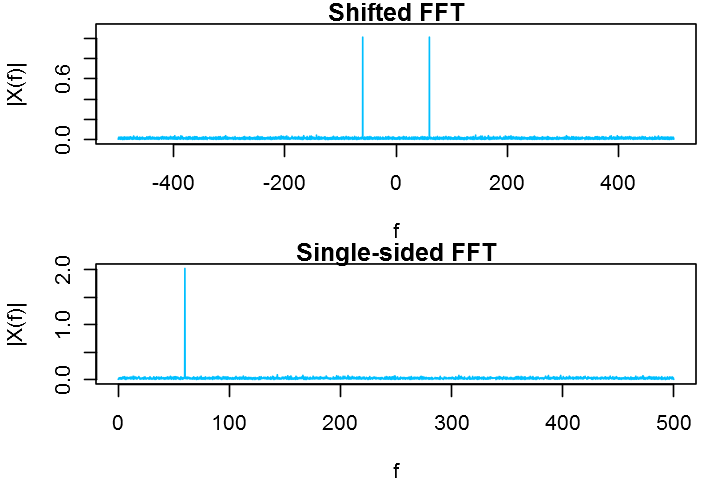

In [4]:
# single-side fft

xnt <- fft(xn) / N
xntss <- xnt[1:(N/2 + 1)]
xntss[2:(length(xntss) - 1)] = 2 * xntss[2:(length(xntss) - 1)]

fss <- f[1:(N / 2 + 1)]

par(mfrow = c(2, 1), mar = c(4, 4, 1, 1))
plot(fs, abs(xntshift), type = 'l', lwd = 1, col = 'deepskyblue', main = "Shifted FFT", xlab = "f", ylab = '|X(f)|', ylim = c(0, 1.1))
plot(fss, abs(xntss), type = 'l', lwd = 1, col = 'deepskyblue', main = "Single-sided FFT", xlab = "f", ylab = '|X(f)|')

## 2. Extract Amplitude of the Specific Frequency
For instance,
$$X_{\text{feature}\ \text{vector}} = \text{amplitude}\ \text{at}\ 1X$$

X1 = 2.028164

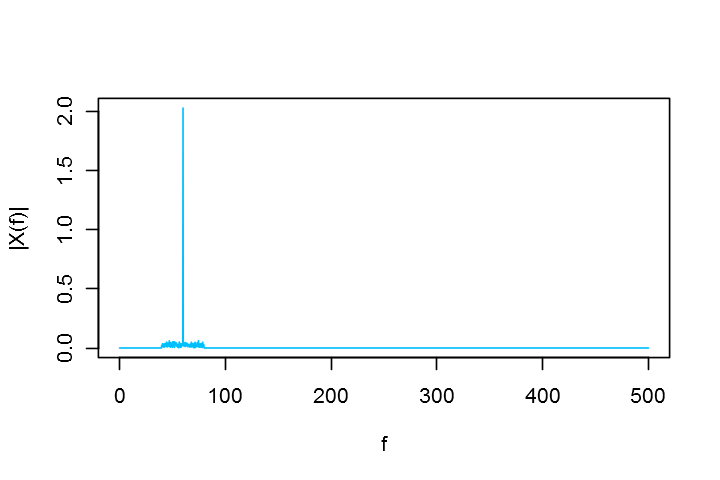

In [5]:
amplitude <- abs(xntss)

f1 <- 60
c <- 20

filter01 <- rep(0, length(fss))
filter01[ceiling(N / Fs * (f1 - c)):ceiling(N / Fs * (f1 + c))] <- 1

X1 <- max(amplitude * filter01)
cat('X1 =', X1)
plot(fss, amplitude * filter01, type = 'l', col = 'deepskyblue', lwd = 1, ylab = '|X(f)|', xlab = 'f')

## 3. Envelope Analysis

### 3.1. Beats
<center><iframe src="https://www.youtube.com/embed/7YEyMLX3sD8?rel=0" 
width="420" height="315" frameborder="0" allowfullscreen></iframe></center>

$$
\text{cos}(2\pi f_1t)\ +\ \text{cos}(2\pi f_2t) = 2\text{cos}\left(2\pi {f_1 + f_2 \over 2}t \right)\text{cos}\left(2\pi {f_1 - f_2 \over 2}t \right)
$$

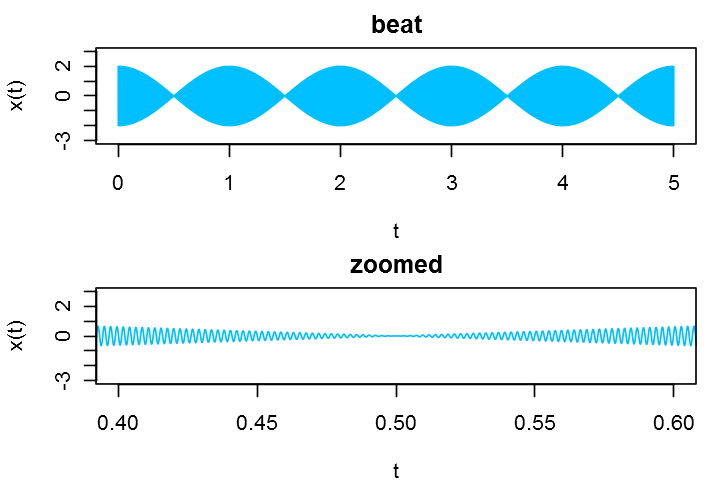

In [6]:
Fs <- 44100  # Smapling frequency
T <- 1 / Fs  # Sampling period (or sampling interval)

N <- 5 * Fs  # Total data points (signal length)

t <- (0:(N - 1)) * T  # Time vector (time range)

k <- 0:(N - 1)  # vector from 0 to N-1
f <- (Fs / N) * k  # frequency range

x <- cos(2 * pi * 440 * t) + cos(2 * pi * 441 * t)

par(mfrow = c(2, 1), mar = c(4, 4, 2, 1))
plot(t, x, type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'beat', xlab = 't', ylab = 'x(t)', ylim = c(-3, 3))
plot(t, x, type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'zoomed', xlab = 't', ylab = 'x(t)', ylim = c(-3, 3), xlim = c(0.4, 0.6))

sound <- function(data, samp.rate) {
  W <- tuneR::normalize(tuneR::Wave(data, samp.rate = samp.rate, bit = 16), unit = "16")
  tuneR::play(W)
}
sound(x, Fs)

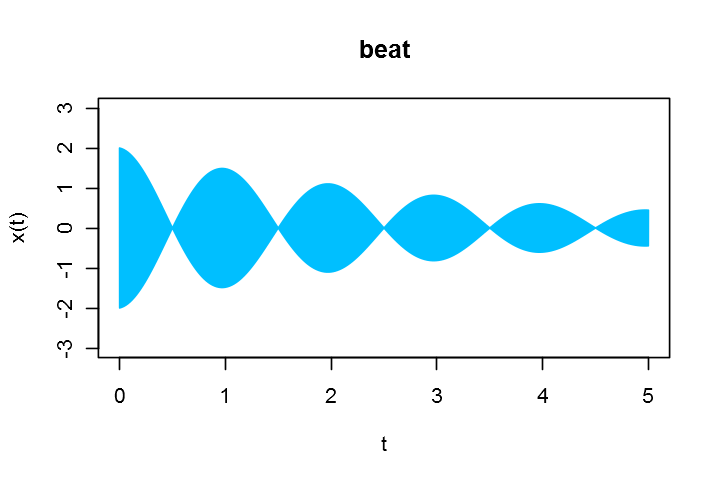

In [7]:
xexp <- x * exp(-0.3 * t)

plot(t, xexp, type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'beat', xlab = 't', ylab = 'x(t)', ylim = c(-3, 3))

sound(xexp, Fs)

### 3.2. Modulation and Demodulation

Modulation is the process of varying one or more properties of a periodic waveform, called the carrier signal, with a modulating signal that typically contains information to be transmitted. Most radio systems in the 20th century used frequency modulation(FM) or amplitude modulation(AM) to make the carrier carry the raido broadcast.


<center>
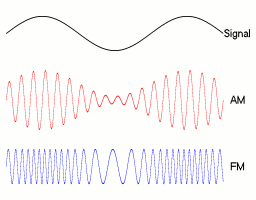
</center>

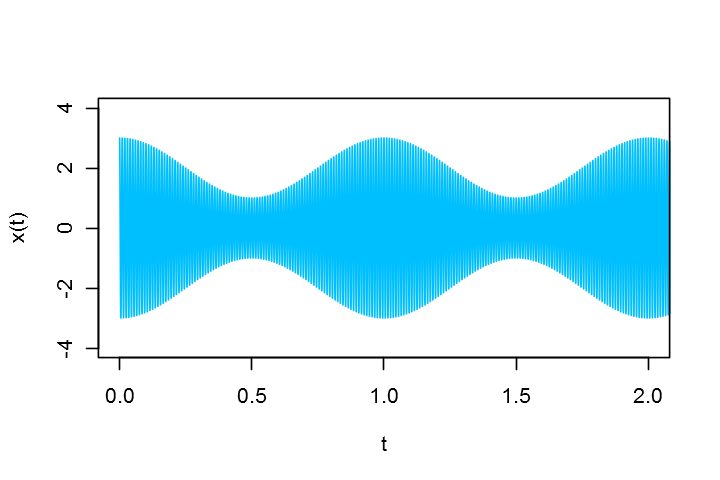

In [8]:
Fs <- 44100  # Smapling frequency
T <- 1 / Fs  # Sampling period (or sampling interval)

N <- Fs * 5 # Total data points (signal length)

t <- (0:(N - 1)) * T  # Time vector (time range)

k <- 0:(N - 1)  # vector from 0 to N-1
f <- (Fs / N) * k  # frequency range

sig <- cos(2 * pi * 1 * t) + 2
carrier <- cos(2 * pi * 100 * t)

x <- sig * carrier

plot(t, x, type = 'l', col = 'deepskyblue', lwd = 1,
     main = '', xlab = 't', ylab = 'x(t)', xlim = c(0, 2), ylim = c(-4, 4))
sound(x, Fs)

$$
\begin{align}
x[n] &= \text{sin}(2\pi f_Ht)(2+\text{sin}(2\pi f_Lt)) \\
&= \text{sin}(2\pi f_Ht)+{\text{cos}(2\pi (f_H - f_L)t)\over 2} + {\text{cos}(2\pi (f_H + f_L) t) \over 2}
\end{align}
$$

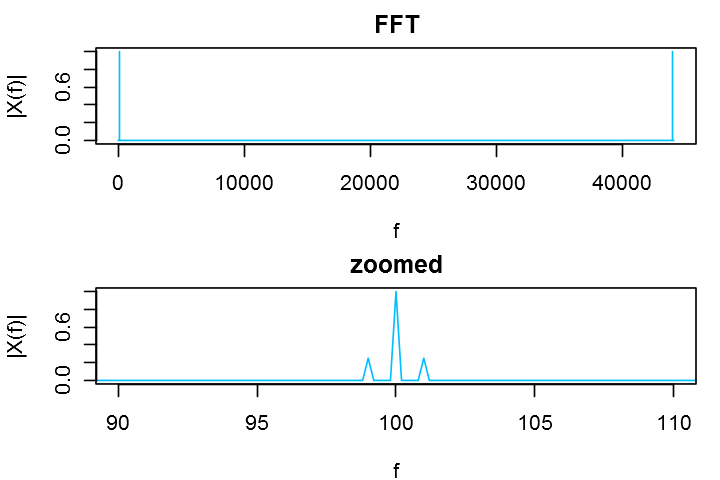

In [9]:
xt <- fft(x) / N

par(mfrow = c(2, 1), mar = c(4, 4, 2, 1))
plot(f, abs(xt), type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'FFT', xlab = 'f', ylab = '|X(f)|')
plot(f, abs(xt), type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'zoomed', xlab = 'f', ylab = '|X(f)|', xlim = c(90, 110))

Hilbert Transform
* Do not worry about the equation. It will give us the envelop of a signal

$$
H(u(t)) = {1 \over \pi} \int_{-\infty}^\infty {u(r) \over t-r}dr
$$

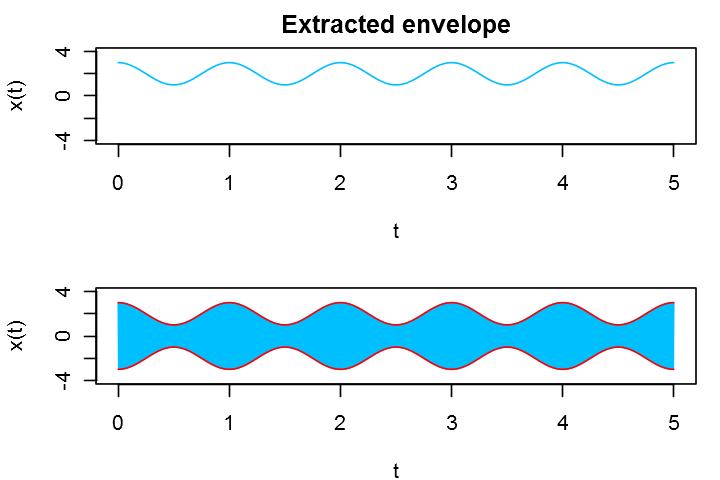

In [10]:
# extract envelope using Hilbert transform
xe <- abs(hht::HilbertTransform(x)) # xe <- hht::HilbertEnvelope(x)
# xe <- abs(seewave::hilbert(x, Fs))

par(mfrow = c(2, 1), mar = c(4, 4, 2, 1))
plot(t, xe, type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'Extracted envelope', xlab = 't', ylab = 'x(t)', ylim = c(-4, 4))
plot(t, x, type = 'l', col = 'deepskyblue', lwd = 1,
     main = '', xlab = 't', ylab = 'x(t)', ylim = c(-4, 4))
matlines(t, cbind(1 * xe, -1 * xe), col = 'red', lty = 1, lwd = 1)

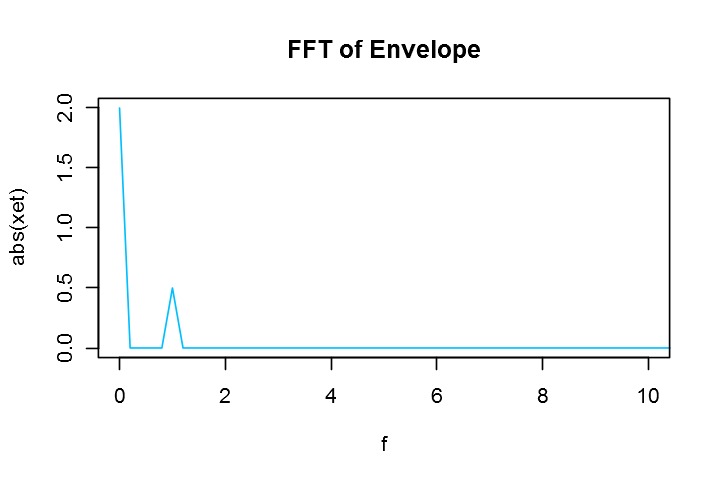

In [11]:
xet <- fft(xe) / N
plot(f, abs(xet), type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'FFT of Envelope', xlab = 'f', xlim = c(0, 10))

## 4. STFT(Short-Time Fourier Transform)

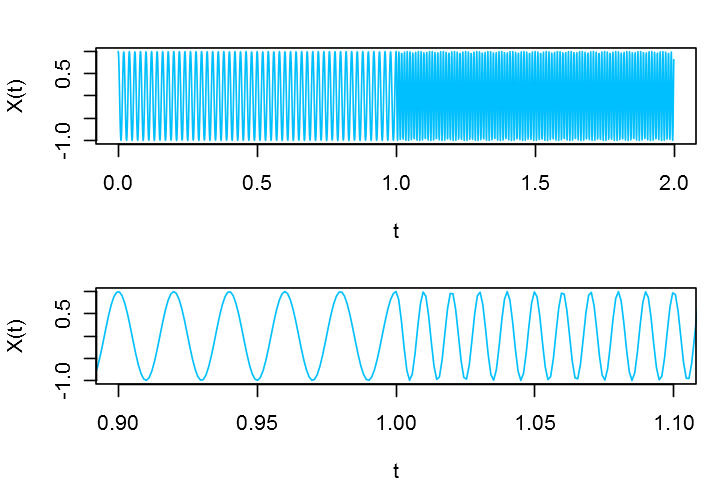

In [12]:
Fs <- 2 ^ 10  # Sampling frequency
T <- 1 / Fs  # Sampling period (or sampling interval)

N <- Fs * 2  # Total data points (signal length)

t <- (0:(N - 1)) * T  # Time vector(time range)

k <- 0:(N - 1)  # vector from 0 to N-1
f <- (Fs / N) * k  # frequency range

x1 <- cos(2 * pi * 50 * t)
x2 <- cos(2 * pi * 100 * t)

x <- rep(0, length(t))
x[1:(N / 2)] <- x1[1:(N / 2)]
x[(N / 2 + 1):length(x)] <- x2[(N / 2 +1):length(x)]

par(mfrow = c(2, 1), mar = c(4, 4, 2, 1))
plot(t, x, type = 'l', col = 'deepskyblue', lwd = 1,
     main = '', xlab = 't', ylab = 'X(t)')
plot(t, x, type = 'l', col = 'deepskyblue', lwd = 1,
     main = '', xlab = 't', ylab = 'X(t)', xlim = c(0.9, 1.1))

FFT does not provide time information of the signal.

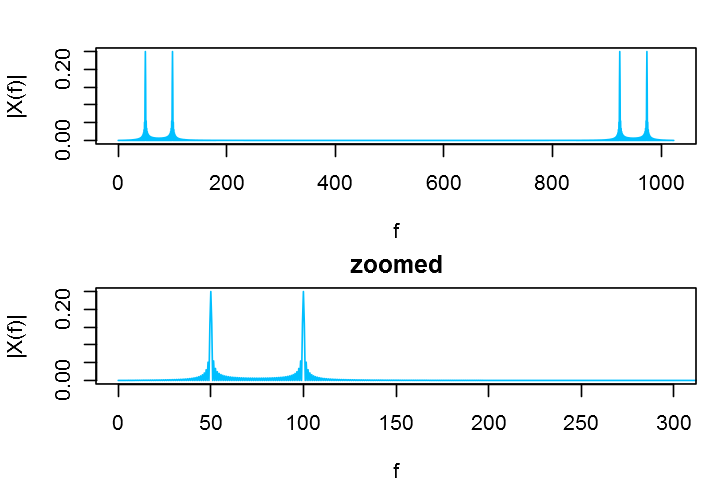

In [13]:
xt <- fft(x) / N

par(mfrow = c(2, 1), mar = c(4, 4, 2, 1))
plot(f, abs(xt), type = 'l', col = 'deepskyblue', lwd = 1,
     main = '', xlab = 'f', ylab = '|X(f)|')
plot(f, abs(xt), type = 'l', col = 'deepskyblue', lwd = 1,
     main = 'zoomed', xlab = 'f', ylab = '|X(f)|', xlim = c(0, 300))

* The spectral content of speech changes over time (non-stationary)
  + As an example, formants change as a function of the spoken phonemes
  + Applying the DFT over a long window does not reveal transitions in spectral content
  
* To avoid this issue, we apply the DFT over short periods of time
  + For short enough windows, speech can be considered to be stationary
  + Remember, though, that there is a time-frequency tradeoff here!

<center>
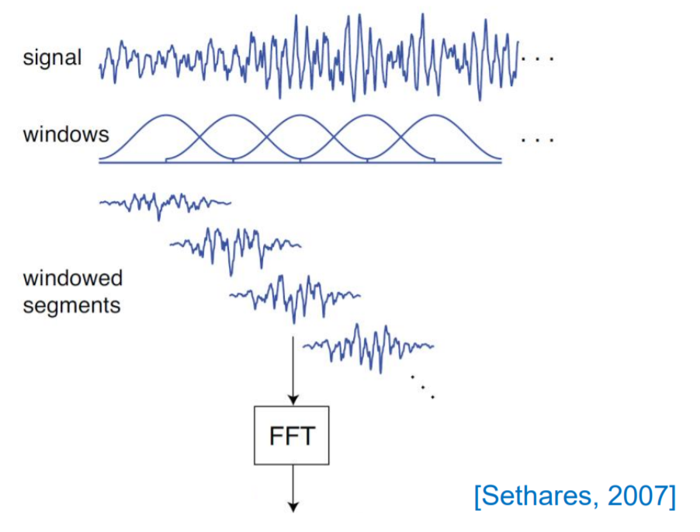
</center>

* Matlab function spectrogram is useful for easily computing STFTs
* R function $spectro$ in $seewave$ package is useful for easily computing STFTs

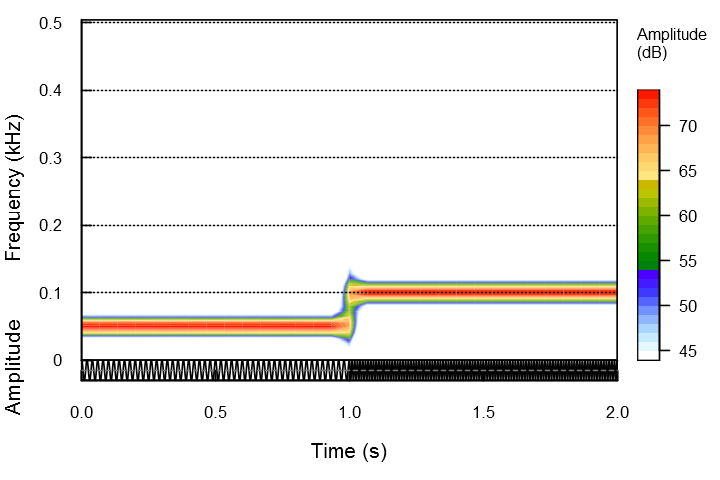

In [14]:
windowsize <- 2 ^ 7
window <- seewave::ftwindow(wl = windowsize, wn = "hanning")
# nfft <- windowsize
noverlab <- windowsize / 2  # 50% in seewave::spectro

STF <- seewave::spectro(wave = x, f = Fs, wl = windowsize, wn = 'hanning',
                 ovlp = 50, osc = T, dBref=2*10e-5)

In [15]:
seewave::spectro3D(wave = x, f = Fs, wl = windowsize, wn = 'hanning',
                 ovlp = 50, dBref=2*10e-5)
suppressPackageStartupMessages(rgl::rglwidget())

HTML widgets cannot be represented in plain text (need html)